## Example: Graph (small molecule) data

For this example, we'll fit a model to predict atomization energy on
the QM9 dataset, a widely used benchmark for this task with about 134,000
molecules. The dataset needs some preprocessing to convert into
a format we can use. We'll need the ase library to be
installed for this.

Molecules are a common form of graph data, and we can of course represent
them in a variety of ways. Here we'll use a very simple approach: one-hot
encode each atom type and weight it based on distance to a central atom.
We then use a graph convolution kernel to pairwise compare all atomic
environments in any two molecules.

Using more sophisticated
representations, we can achieve performance competitive with state
of the art. What's interesting about this simple representation,
however, is that it can already achieve fairly good performance,
with a mean absolute error of about 1 kcal / mol (the so-called
"chemical accuracy" threshold), despite its simplicity, nicely
demonstrating the usefulness of graph convolution kernels.
Also, this demo illustrates some of the mechanics of tuning
and fitting for convolution kernels with xGPR.

All experiments here are on an A6000 GPU.

In [1]:
import os
import shutil
import time
import tarfile
import wget
import ase
from ase.io import read
import subprocess
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

from xGPR.xGP_Regression import xGPRegression as xGPReg
from xGPR.data_handling.dataset_builder import build_offline_sequence_dataset

In [2]:
#Retrieving the raw data -- this might take a minute...
qm9_yvals_url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"
qm9_xyz_url = "https://figshare.com/ndownloader/files/3195389"
fname = wget.download(qm9_yvals_url)
fname = wget.download(qm9_xyz_url)
tarball = tarfile.open(fname)
tarball.extractall("qm9_mols")
os.remove(fname)

#We have to clean up the downloaded files a little.
os.chdir("qm9_mols")
for f in os.listdir():
    with open(f, "r") as fhandle:
        raw_file = fhandle.readlines()
    raw_file = [l.replace("*^", "e") for l in raw_file]
    with open(f, "w+") as fhandle:
        for line in raw_file[:-3]:
            fhandle.write(line)

os.chdir("..")

 14% [..........                                                              ]  4349952 / 29856825

 67% [................................................                        ] 20086784 / 29856825

100% [........................................................................] 29856825 / 29856825

100% [........................................................................] 86144227 / 86144227

In [3]:
os.chdir("qm9_mols")
xfiles = [os.path.abspath(f) for f in os.listdir()]
xfiles.sort()

#The common practice for this in the literature
#has been to use 110,000 mols for training,
#remainder for test & validation. We'll follow
#that here.
random.seed(123)
random.shuffle(xfiles)

train_x, test_x = xfiles[:110000], xfiles[110000:]

os.chdir("..")

labels = pd.read_csv("qm9.csv")
mol_dict = { k.split("_")[-1]:v for (k,v) in zip(labels.mol_id.tolist(), labels.u298_atom.tolist())} 

Here we encode each molecule as a matrix where each row is one atom; the features
in that row are one-hot encodings of all other atoms (out to the nearest 15)
weighted by how far away they are, using 1/r**6 weighting (this is
used to construct a London matrix, which is why we use it here).
This could easily be optimized for faster feature generation if desired,
but again, our goal here is merely a simple demonstration.

In [4]:
def encode_mols(x_file_list, y_value_dict, chunk_size, ftype = "train"):
    x_batch, y_batch = [], []
    x_fnames, y_fnames = [], []
    fcounter = 0

    atom_key = {"H":0, "C":1, "O":2, "N":3, "F":4}
    num_atom_types = len(atom_key)
    max_partners = 15
    
    for xfile in x_file_list:
        #Each molecule has up to 29 atoms
        output_mat = np.zeros((29, num_atom_types * max_partners), dtype=np.float32)

        mol = read(xfile)
        f_key = str(int(xfile.split("_")[-1].split(".xyz")[0]))
        y_batch.append(y_value_dict[f_key])

        positions, symbols = mol.get_positions(), mol.get_chemical_symbols()
        dist_mat = distance_matrix(positions, positions)
        idx_by_dist = np.argsort(dist_mat, axis=1)

        for i, symbol in enumerate(symbols):
            #One-hot encode the central atom
            output_mat[i,atom_key[symbol]] = 1
            for j, idx in enumerate(idx_by_dist[i,1:max_partners].tolist()):
                atom_offset = (j + 1) * num_atom_types + atom_key[symbols[idx]]
                output_mat[i, atom_offset] = 1 / dist_mat[i,idx]**6

        x_batch.append(output_mat)
        
        if len(x_batch) >= chunk_size:
            x_fnames.append(f"{ftype}_{fcounter}_xbatch.npy")
            y_fnames.append(f"{ftype}_{fcounter}_ybatch.npy")
            np.save(x_fnames[-1], np.stack(x_batch))
            np.save(y_fnames[-1], np.asarray(y_batch))
            x_batch, y_batch = [], []
            fcounter += 1

In [5]:
#We now encode all the raw data...this might take a minute.
encode_mols(train_x, mol_dict, chunk_size = 1000, ftype="train")
encode_mols(test_x, mol_dict, chunk_size = 1000, ftype="test")

In [2]:
train_x_files, train_y_files, test_x_files, test_y_files = [], [], [], []
for f in os.listdir():
    if f.startswith("train"):
        if f.endswith("xbatch.npy"):
            train_x_files.append(f)
        elif f.endswith("ybatch.npy"):
            train_y_files.append(f)
    elif f.startswith("test"):
        if f.endswith("xbatch.npy"):
            test_x_files.append(f)
        elif f.endswith("ybatch.npy"):
            test_y_files.append(f)

train_x_files.sort(key=lambda x: int(x.split("_xbatch.npy")[0].split("_")[-1]))
test_x_files.sort(key=lambda x: int(x.split("_xbatch.npy")[0].split("_")[-1]))

train_y_files.sort(key=lambda x: int(x.split("_ybatch.npy")[0].split("_")[-1]))
test_y_files.sort(key=lambda x: int(x.split("_ybatch.npy")[0].split("_")[-1]))

In [3]:
#Notice that for graph data, we use build_offline_sequence_dataset just as
#we do for sequences -- there is no separate function.
train_dset = build_offline_sequence_dataset(train_x_files, train_y_files, chunk_size = 1000)

We'll use GraphConv1d as the kernel, a convolution kernel with a conv_width of 1. This is generally faster than the sequence convolution kernels but slower than Matern or RBF. For a larger dataset we can set "subsample" to some value less than 1 to randomly sample a subset of the data. We can also use crude_bayes as in the tabular data tutorial or crude_lbfgs. ``crude_grid`` is extremely simple
and easy to work with, which is sometimes an advantage.

In [12]:
init_model = xGPReg(training_rffs = 1024, fitting_rffs = 8192, variance_rffs = 1024,
                   kernel_choice = "GraphConv1d", verbose = True,
                   device = "gpu")

best_hparams, _, best_score, scores = init_model.tune_hyperparams_crude_grid(train_dset,
                                                                          n_gridpoints = 20)

starting_tuning
Grid point 0 acquired.
Grid point 1 acquired.
Grid point 2 acquired.
Grid point 3 acquired.
Grid point 4 acquired.
Grid point 5 acquired.
Grid point 6 acquired.
Grid point 7 acquired.
Grid point 8 acquired.
Grid point 9 acquired.
Grid point 10 acquired.
Grid point 11 acquired.
Grid point 12 acquired.
Grid point 13 acquired.
Grid point 14 acquired.
Grid point 15 acquired.
Grid point 16 acquired.
Grid point 17 acquired.
Grid point 18 acquired.
Grid point 19 acquired.
Best score achieved: -227938.641
Best hyperparams: [-3.4927146 -1.6094379  2.1813964]
Tuning complete.


We can plot how the score varies as a function of the kernel-specific hyperparameter
during the gridsearch. We see that good scores are concentrated around lengthscale
2 IF tuning with 1024 random features. The location of this minimum will shift
as we use more random features.

Note that if the range of lengthscales which give close-to-optimal scores
for GraphConv1d is ever very broad, this is a good sign that the GraphPoly
polynomial kernel is likely to give performance nearly as good (or possibly
slightly better). This can be advantageous since GraphPoly has only two
hyperparameters so is very easy to tune.

Text(0, 0.5, 'Score')

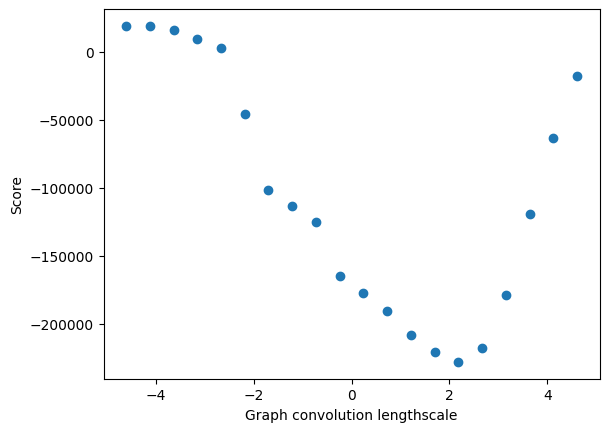

In [15]:
plt.scatter(np.concatenate(scores[0]), scores[1])
plt.xlabel("Graph convolution lengthscale")
plt.ylabel("Score")

Let's use a slightly finer grid with more random features to narrow down the region of interest.
First, we'll ask xGPR to suggest some new boundaries for optimization for us. ``crude`` methods
like ``crude_bayes``, ``crude_lbfgs`` and ``crude_grid`` are often better at finding a good
lengthscale than at finding the best value for the first two hyperparameters (lambda and beta),
so we'll set ``consider_all_shared`` to True, to ensure the suggested bounds encompass the
default bounds for lambda and beta. Notice that the optimal value for beta (hyperparamter 2)
is up against a default bound; this is one situation where expanding the search boundaries
might actually be beneficial.

In [17]:
new_bounds = init_model.suggest_bounds(box_width = 1, consider_all_shared = True)
print(new_bounds)

[[-6.90775528  2.30258509]
 [-1.60943791  1.60943791]
 [ 1.2         3.2       ]]


In [20]:
init_model.training_rffs = 2048
best_hparams, _, best_score, scores = init_model.tune_hyperparams_crude_grid(train_dset,
                                                            bounds = new_bounds, n_gridpoints = 10)

starting_tuning
Grid point 0 acquired.
Grid point 1 acquired.
Grid point 2 acquired.
Grid point 3 acquired.
Grid point 4 acquired.
Grid point 5 acquired.
Grid point 6 acquired.
Grid point 7 acquired.
Grid point 8 acquired.
Grid point 9 acquired.
Best score achieved: -239199.521
Best hyperparams: [-3.6281066 -1.6094379  2.3111111]
Tuning complete.


Now we'll build a preconditioner and fit. In this case, since the
dataset is small, we're unlikely to have a disk space issue if
we pre-generate the random features then load them
as needed from disk. For a convolution kernel, this will speed up
the fitting process somewhat compared to generating them on the
fly (usually).

In [29]:
init_model.fitting_rffs = 16384
if "pretransformed_data" not in os.listdir():
    os.mkdir("pretransformed_data")

pretransform_path = os.path.join(os.getcwd(), "pretransformed_data")
pretransformed_data = init_model.pretransform_data(train_dset, pretransform_path)

Now pretransforming data.


The preconditioner ratio using a max_rank of 1000 is on the high side, which means
that the model *might* take more iterations than usual to fit. To avoid this,
we can use a higher ``max_rank``. This increases the cost of preconditioner construction
but will reduce the number of CG iterations required to fit.

In [30]:
start_time = time.time()
preconditioner, ratio = init_model.build_preconditioner(pretransformed_data, max_rank = 1500,
                                                      method = "srht_2")
end_time = time.time()
print(f"Wallclock: {end_time - start_time}")
print(f"Preconditioner ratio: {np.round(ratio,4)}")

Chunk 0 complete.
Chunk 10 complete.
Chunk 20 complete.
Chunk 30 complete.
Chunk 40 complete.
Chunk 50 complete.
Chunk 60 complete.
Chunk 70 complete.
Chunk 80 complete.
Chunk 90 complete.
Chunk 100 complete.
Chunk 0 complete.
Chunk 10 complete.
Chunk 20 complete.
Chunk 30 complete.
Chunk 40 complete.
Chunk 50 complete.
Chunk 60 complete.
Chunk 70 complete.
Chunk 80 complete.
Chunk 90 complete.
Chunk 100 complete.
Wallclock: 29.582849979400635
Preconditioner ratio: 26.4128


We use a tighter tol than usual here, since the data is noise-free
enough that small improvements in accuracy matter. (Note that
tol = 1e-8 is usually overkill however; 1e-7 is generally
tight enough).

In [31]:
start_time = time.time()
init_model.fit(pretransformed_data, preconditioner = preconditioner, mode = 'cg',
             max_iter = 500, tol=1e-7)
end_time = time.time()
print(f"Wallclock: {end_time - start_time}")

starting fitting
Iteration 0
Iteration 5
Iteration 10
Iteration 15
Estimating variance...
Variance estimated.
Fitting complete.
Wallclock: 71.81164789199829


In [32]:
start_time = time.time()
all_preds, ground_truth = [], []
for xfile, yfile in zip(test_x_files, test_y_files):
    x, y = np.load(xfile), np.load(yfile)
    ground_truth.append(y)
    preds = init_model.predict(x, get_var = False)
    all_preds.append(preds)
    
all_preds, ground_truth = np.concatenate(all_preds), np.concatenate(ground_truth)
end_time = time.time()
print(f"Wallclock: {end_time - start_time}")


print("Mean absolute error:")
print(np.round(np.mean(np.abs(all_preds - ground_truth)), 5))

#Clean up the pre-generated random features we generated for fitting.
pretransformed_data.delete_dataset_files()
del pretransformed_data

Wallclock: 1.123892068862915
Mean absolute error:
1.41587


Not bad...for a start. We're already at an MAE of 1.4 ("chemical accuracy" is widely considered to be
1 kcal/mol). We're already outperforming the deep learning models described in the MoleculeNet paper. But of course we'd like to get to 1 kcal/mol. Let's see how we can make this better using the existing features (without doing more feature engineering).

We can increase the number of random features for fitting, and /or we can also fine-tune our hyperparameters. Thist next
part took a little over an hour when we ran it, saving pre-generated features to disk on each run, but this may depend on your hardware (we used an A6000 GPU with an SSD; the SSD makes loading pre-generated features from disk faster, so that pre-generating features is definitely a good option).

First, let's tune using a larger number of random features. The two class methods for tuning with approximate marginal likelihood (``tune_hyperparams_fine_direct`` and
``tune_hyperparams_fine_bayes``) both essentially fit the model repeatedly, so any settings that we found helpful for fitting, are likely helpful for this fine-tuning. Notice that ``tune_hyperparams_fine_direct`` only works well if we have a good starting point from which we can "see" the global optimum. ``tune_hyperparams_fine_bayes``, by contrast, works better if the global optimum may be a little farther off from our starting point. In general we prefer ``fine_bayes``, although it does usually take more iterations since it is conducting a global search, and it needs to have a good set of boundaries so it doesn't try to search the whole hyperparameter space.

Tuning with max_bayes_iter of 35 will essentially work out to
fitting the model up to 35x, so if fitting the model once takes a couple minutes, you can see how much time this is likely to take. As discussed, this approach is slower -- but also more scalable -- than ``crude_bayes`` or ``crude_lbfgs``. Increasing max_bayes_iter will increase the chances of finding the best possible hyperparameters,
but may of course take longer. This routine will terminate early if it finds it's checking points very close to any it's evaluated already as well.

Since we found that ``max_rank = 1500`` to be helpful when fitting earlier, we'll also use that setting for approximate marginal likelihood calculations -- it will help speed
things up and ensure the approximation is correct. Second, we can supply a ``pretransform_dir`` just as we
did when fitting for the same reason. Since we used ``tol`` of 1e-7 for fitting, we'll use ``nmll_tol = 1e-7`` here as well.

To get the bounds we're using here, we set a bounding box around the hyperparameters found by "crude" tuning. One way to do this is by calling``init_model.suggest_bounds(box_width=1.5)``
creates a bounding box that is 1.5 * 2 wide and clips that box anywhere it exceeds the default boundaries
for this kernel. We could adjust this manually as well, since that box is actually bigger in some
directions than we probably need. For the first hyperparameter (lambda), for example, the data is fairly
noise-free, so we know that small values of lambda are more likely.

In [33]:
init_model.suggest_bounds(1.5)

array([[-5.1       , -2.1       ],
       [-1.60943791, -0.1       ],
       [ 0.8       ,  3.8       ]])

In [34]:
init_model.training_rffs = 8192

start_time = time.time()
bounds = np.array([[-6, -3],
       [-1.60943791, 0],
       [ 0.8,  3.8 ]])
init_model.tune_hyperparams_fine_bayes(train_dset, bounds = bounds,
                    random_seed = 123, max_bayes_iter = 35, nmll_tol = 1e-7,
                    nmll_rank = 1500, pretransform_dir = pretransform_path)
end_time = time.time()

print(f"Wallclock: {end_time - start_time}")

starting_tuning
Now pretransforming data.
Now building preconditioner...
Now fitting...
NMLL evaluation completed.
Point 0 acquired.
Now pretransforming data.
Now building preconditioner...
Now fitting...
NMLL evaluation completed.
Point 1 acquired.
Now pretransforming data.
Now building preconditioner...
Now fitting...
NMLL evaluation completed.
Point 2 acquired.
Now pretransforming data.
Now building preconditioner...
Now fitting...
NMLL evaluation completed.
Point 3 acquired.
Now pretransforming data.
Now building preconditioner...
Now fitting...
NMLL evaluation completed.
Point 4 acquired.
Now pretransforming data.
Now building preconditioner...
Now fitting...
NMLL evaluation completed.
Point 5 acquired.
Now pretransforming data.
Now building preconditioner...
Now fitting...
NMLL evaluation completed.
Point 6 acquired.
Now pretransforming data.
Now building preconditioner...
Now fitting...
NMLL evaluation completed.
Point 7 acquired.
Now pretransforming data.
Now building precondit

In [35]:
print(init_model.get_hyperparams())

[-4.92715572 -1.17913654  2.58527418]


In [36]:
init_model.fitting_rffs = 16384
if "pretransformed_data" not in os.listdir():
    os.mkdir("pretransformed_data")

pretransform_path = os.path.join(os.getcwd(), "pretransformed_data")
pretransformed_data = init_model.pretransform_data(train_dset, pretransform_path)

start_time = time.time()
preconditioner, ratio = init_model.build_preconditioner(pretransformed_data, max_rank = 1500,
                                                      method = "srht_2")
end_time = time.time()
print(f"Wallclock: {end_time - start_time}")
print(f"Preconditioner ratio: {np.round(ratio, 4)}")

start_time = time.time()
init_model.fit(pretransformed_data, preconditioner = preconditioner, mode = 'cg',
             max_iter = 500, tol=1e-7)
end_time = time.time()
print(f"Wallclock: {end_time - start_time}")

Now pretransforming data.
Chunk 0 complete.
Chunk 10 complete.
Chunk 20 complete.
Chunk 30 complete.
Chunk 40 complete.
Chunk 50 complete.
Chunk 60 complete.
Chunk 70 complete.
Chunk 80 complete.
Chunk 90 complete.
Chunk 100 complete.
Chunk 0 complete.
Chunk 10 complete.
Chunk 20 complete.
Chunk 30 complete.
Chunk 40 complete.
Chunk 50 complete.
Chunk 60 complete.
Chunk 70 complete.
Chunk 80 complete.
Chunk 90 complete.
Chunk 100 complete.
Wallclock: 29.509470462799072
Preconditioner ratio: 1864.5666687707335
starting fitting
Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 25
Iteration 30
Iteration 35
Iteration 40
Iteration 45
Iteration 50
Iteration 55
Iteration 60
Iteration 65
Estimating variance...
Variance estimated.
Fitting complete.
Wallclock: 231.10954570770264


In [37]:
if "pretransformed_data" in os.getcwd():
    os.chdir("..")

start_time = time.time()
all_preds, ground_truth = [], []
for xfile, yfile in zip(test_x_files, test_y_files):
    x, y = np.load(xfile), np.load(yfile)
    ground_truth.append(y)
    preds = init_model.predict(x, get_var = False)
    all_preds.append(preds)
    
all_preds, ground_truth = np.concatenate(all_preds), np.concatenate(ground_truth)
end_time = time.time()
print(f"Wallclock: {end_time - start_time}")

print("Mean absolute error:")
print(np.round(np.mean(np.abs(all_preds - ground_truth)), 4))

pretransformed_data.delete_dataset_files()

Wallclock: 1.1123247146606445
Mean absolute error:
1.1544


Text(0.5, 1.0, 'Predicted vs actual post fine-tuning,\nfitting with 16384 random features')

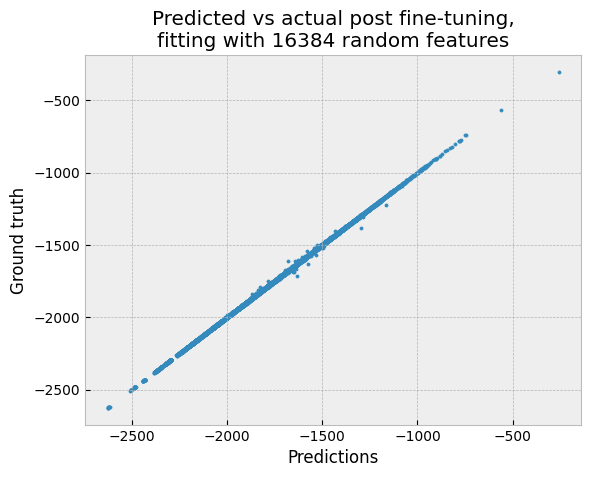

In [38]:
plt.style.use("bmh")
plt.scatter(all_preds, ground_truth, s = 5)
plt.xlabel("Predictions")
plt.ylabel("Ground truth")
plt.title("Predicted vs actual post fine-tuning,\nfitting with 16384 random features")

Retuning worked pretty well -- we're down to a mean absolute error of 1.11 kcal/mol, substantially better than any of the MoleculeNet deep learning models.

Just for fun, let's see what happens if we fit with 2x more random features. This will result in slower fitting, and will make generating predictions slower. As always, remember that increasing the number of RFFs for either tuning or
fitting provides diminishing returns -- going from 4096 to 8192 provides a more significant boost than going from 8192 to 16384 and so on.

In [39]:
init_model.fitting_rffs = 32768
if "pretransformed_data" not in os.listdir():
    os.mkdir("pretransformed_data")

pretransform_path = os.path.join(os.getcwd(), "pretransformed_data")
pretransformed_data = init_model.pretransform_data(train_dset, pretransform_path)

start_time = time.time()
preconditioner, ratio = init_model.build_preconditioner(pretransformed_data, max_rank = 1500,
                                                      method = "srht_2")
end_time = time.time()
print(f"Wallclock: {end_time - start_time}")
print(f"Preconditioner ratio: {np.round(ratio, 4)}")

start_time = time.time()
init_model.fit(pretransformed_data, preconditioner = preconditioner, mode = 'cg',
             max_iter = 500, tol=1e-7)
end_time = time.time()
print(f"Wallclock: {end_time - start_time}")

Now pretransforming data.
Chunk 0 complete.
Chunk 10 complete.
Chunk 20 complete.
Chunk 30 complete.
Chunk 40 complete.
Chunk 50 complete.
Chunk 60 complete.
Chunk 70 complete.
Chunk 80 complete.
Chunk 90 complete.
Chunk 100 complete.
Chunk 0 complete.
Chunk 10 complete.
Chunk 20 complete.
Chunk 30 complete.
Chunk 40 complete.
Chunk 50 complete.
Chunk 60 complete.
Chunk 70 complete.
Chunk 80 complete.
Chunk 90 complete.
Chunk 100 complete.
Wallclock: 58.350807905197144
Preconditioner ratio: 1891.6778991173296
starting fitting
Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 25
Iteration 30
Iteration 35
Iteration 40
Iteration 45
Iteration 50
Iteration 55
Iteration 60
Iteration 65
Iteration 70
Iteration 75
Estimating variance...
Variance estimated.
Fitting complete.
Wallclock: 470.23130083084106


In [40]:
if "pretransformed_data" in os.getcwd():
    os.chdir("..")

start_time = time.time()
all_preds, ground_truth = [], []
for xfile, yfile in zip(test_x_files, test_y_files):
    x, y = np.load(xfile), np.load(yfile)
    ground_truth.append(y)
    preds = init_model.predict(x, get_var = False)
    all_preds.append(preds)
    
all_preds, ground_truth = np.concatenate(all_preds), np.concatenate(ground_truth)
end_time = time.time()
print(f"Wallclock: {end_time - start_time}")

print("Mean absolute error:")
print(np.round(np.mean(np.abs(all_preds - ground_truth)), 4))

pretransformed_data.delete_dataset_files()

Wallclock: 2.0480058193206787
Mean absolute error:
0.9726


Text(0.5, 1.0, 'Predicted vs actual post fine-tuning,\nfitting with 32768 random features')

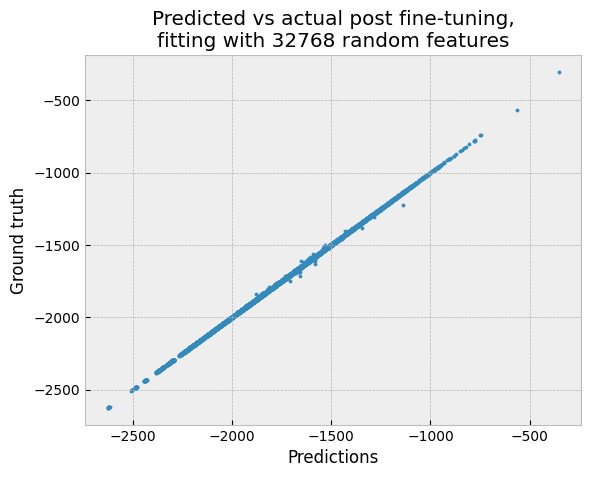

In [41]:
plt.style.use("bmh")
plt.scatter(all_preds, ground_truth, s = 5)
plt.xlabel("Predictions")
plt.ylabel("Ground truth")
plt.title("Predicted vs actual post fine-tuning,\nfitting with 32768 random features")

Notice a couple of interesting things. The mean absolute error is below 1 kcal/mol, which is
chemical accuracy -- pretty good for a generic convolution kernel with one-hot encoded input!
And we can still make predictions for 20,000 molecules in a couple seconds on GPU.

We can improve on this further by doing some more hyperparameter fine-tuning
or increasing the number of fitting RFFs, but these will just provides some incremental improvement (recall that
increasing the number of random features provides diminishing returns). So, further tweaking might give us some additional small improvement, but it's very unlikely to get us down to 0.5 or 0.25 kcal/mol (if that was our goal). Once we've fine-tuned with 8192 RFFs and fitted using a decent number of RFFs
(e.g. 16384), further improvements from "tweaking" are likely to be modest. (Still, sometimes a modest improvement is worth a little extra time and effort...)

To get a much larger improvement we need a more
informative representation of the input molecules (the representation
we used basically discards all information about bond angles etc).
We've been able to reach < 0.17 kcal/mol using SOAP features
(and there are other ways to do this as well). The same interestingly
is true in this case for deep learning models -- deep learning models provided with
uninformative representations (e.g. one hot encoding) often perform much worse than
xGPR does here (see the MoleculeNet paper for example). So, for both deep learning and
GPs, predicting energy with MAE << 1 kcal/mol seems to require more informative features.

In [42]:
#File cleanup.
pretransformed_data.delete_dataset_files()
train_dset.delete_dataset_files()
for xfile, yfile in zip(test_x_files, test_y_files):
    os.remove(xfile)
    os.remove(yfile)

shutil.rmtree("qm9_mols")
shutil.rmtree("pretransformed_data")
os.remove("qm9.csv")